### How many realisations do we need to appropriately constrain the models latent function and stddev?

To look at this we'll use the CanESM model which has 50 historical realisations (the largest in CMPI6) and sample the realisations multiple times and evaluate the agreement between different ensembled outputs



In [5]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
import tqdm
from jax.config import config
import seaborn as sns
import numpy as np 
import xarray as xr

from joblib import Parallel, delayed

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def load_n_realisations(n=5):
    model_file = 'data/gmst/historical/gmst_CCCma_CanESM5_historical.nc'
    da = xr.open_dataarray(model_file)
    col_names = list(da.realisation.values)
    np.random.shuffle(col_names)
    realisation_coord = da.realisation.copy(data=col_names)
    da = da.reindex(realisation=realisation_coord)

    model_data = es.ProcessModel(da, 'CanESM5')
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    model_collection = es.ModelCollection([anomaly_model])
    return model_collection

<AxesSubplot:title={'center':'CanESM5 anomaly'}>

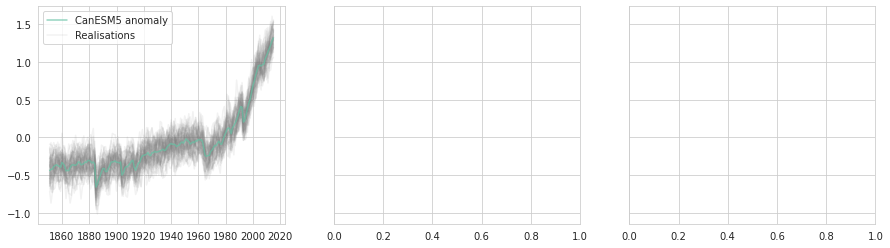

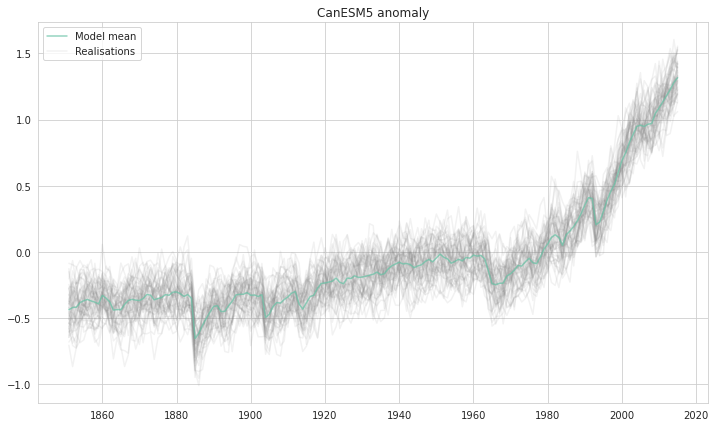

In [7]:
can_hist = load_n_realisations()
can_hist.plot_grid()
can_hist[0].plot()

Using the GPDTW (a Gaussian process fit of the dynamic time warping output)

In [8]:
n_samples_of_each_realisation = 25
max_realisations = 15
min_realisations = 1

# Load 'true' mean and std
can_hist = load_n_realisations(50)
can_hist.fit(model=es.GPDTW(), compile_objective=True, n_optim_nits=750)
true_mean = can_hist.distributions()['CanESM5 anomaly'].mean()
true_std = can_hist.distributions()['CanESM5 anomaly'].variance()

100%|██████████| 750/750 [00:36<00:00, 20.56it/s, loss=-127.93]


In [9]:
def return_mean_var_output(n_reals):
    can_hist = load_n_realisations(n_reals)
    can_hist.fit(model=es.GPDTW(), compile_objective=True, n_optim_nits=500)
    # Estimate mean and variance from the fitted distribution
    mean = can_hist.distributions()['CanESM5 anomaly'].mean()
    std = can_hist.distributions()['CanESM5 anomaly'].variance()

    # Calculate the RMSE between the true and estimated
    mean_error = jnp.power(jnp.mean(jnp.power((mean - true_mean), 2)), 0.5)
    std_error = jnp.power(jnp.mean(jnp.power((std - true_std), 2)), 0.5)

    return mean_error, std_error

In [10]:
x = []
mean_spread = []
std_spread = []
for n_reals in tqdm.trange(min_realisations, max_realisations):
    means = []
    variances = []
    results = Parallel(n_jobs=10)(delayed(return_mean_var_output)(n_reals) for i in range(n_samples_of_each_realisation))
    results = jnp.asarray(results)
    x.append(n_reals)
    mean_spread.append(jnp.asarray(results)[:, 0])
    std_spread.append(jnp.asarray(results)[:, 1])

    # plt.figure()
    # plt.boxplot(np.asarray(mean_spread).T, labels=x)
    # plt.ylabel('RMSE in mean prediction')
    # plt.xlabel('Number of realisations')
    # plt.savefig(f'test{n_reals}.png')
    # plt.close()

 64%|██████▍   | 9/14 [16:38<09:14, 110.98s/it]


KeyboardInterrupt: 

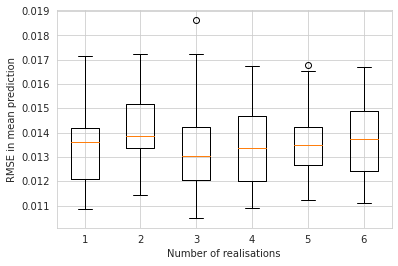

In [ ]:
plt.boxplot(np.asarray(mean_spread).T, labels=x)
plt.ylabel('RMSE in mean prediction')
plt.xlabel('Number of realisations')
plt.show()

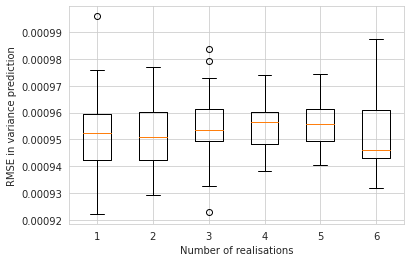

In [ ]:
plt.boxplot(np.asarray(std_spread).T, labels=x)
plt.ylabel('RMSE in variance prediction')
plt.xlabel('Number of realisations')
plt.show()